# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    #series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

# Import data

In [4]:
df = pd.read_csv('../Data/merged_dataset.csv')

df.set_index('Date',inplace=True)

print(df.head())

            carbon_price  oil_price  gas_price  stock_market_index_level  hupx
Date                                                                          
2017-01-02          6.12        NaN       3.71                       NaN   NaN
2017-01-03          5.43      52.36       3.41               3315.020020   NaN
2017-01-04          5.72      53.26       3.42               3317.520020   NaN
2017-01-05          5.29      53.77       3.42               3316.469971   NaN
2017-01-06          5.50      53.98       3.38               3321.169922   NaN


In [7]:
news_df = pd.read_csv('../Data/carbon_news_mentions_sma_30.csv')

news_df.set_index('SQLDATE',inplace=True)

print(news_df.head())
print(news_df.tail())

            SMA_30
SQLDATE           
2020-01-06     NaN
2020-01-07     NaN
2020-01-08     NaN
2020-01-12     NaN
2020-01-13     NaN
              SMA_30
SQLDATE             
2021-05-26  4.066667
2021-05-28  4.100000
2021-05-29  4.000000
2021-05-31  4.033333
2021-06-01  4.333333


# Data preprocessing

## Handle missing values

In [8]:
df = df.fillna(method='bfill')

## Stationarity checks

In [9]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: carbon_price is 1-order integrated (linear difference)!
Variable: oil_price is 1-order integrated (linear difference)!
Variable: gas_price is 0-order integrated (linear difference)!
Variable: stock_market_index_level is 1-order integrated (linear difference)!
Variable: hupx is 1-order integrated (linear difference)!


In [10]:
df_stationer

,carbon_price,oil_price,gas_price,stock_market_index_level,hupx
Date,,,,,
2017-01-02,NaN,NaN,3.71,NaN,NaN
2017-01-03,-0.69,0.00,3.41,0.000000,0.000000
2017-01-04,0.29,0.90,3.42,2.500000,0.000000
2017-01-05,-0.43,0.51,3.42,-1.050049,0.000000
2017-01-06,0.21,0.21,3.38,4.699951,0.000000
...,...,...,...,...,...
2021-04-07,-0.38,0.43,2.43,-13.649902,10.769167
2021-04-08,-0.38,-0.16,2.47,21.060058,3.313750
2021-04-09,0.18,-0.32,2.48,1.010010,-5.000000


In [11]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

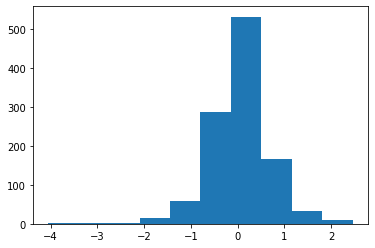

In [12]:
plt.hist(df_stationer.carbon_price)
plt.show()

# Modelling

In [18]:
# Merge changes in carbon price and the news sentiment
merged_df = df_stationer['carbon_price'].to_frame().merge(news_df,
                                                          left_index=True, right_index=True, how='inner')

merged_df = merged_df.dropna()

merged_df.head()

,carbon_price,SMA_30
2020-02-11,0.14,4.166667
2020-02-12,0.58,4.033333
2020-02-13,0.52,4.066667
2020-02-14,-0.11,4.100000
2020-02-17,0.76,3.866667


In [24]:
# Create volatility metric
merged_df['carbon_price_vol'] = abs(merged_df['carbon_price']) #**2

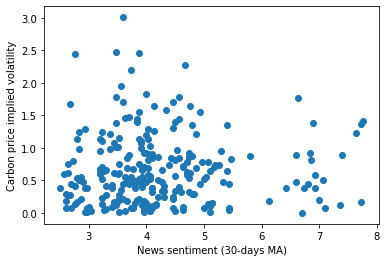

In [27]:
# Compare prediction and actual in the test set
plt.scatter(merged_df['SMA_30'],merged_df['carbon_price_vol'])
plt.xlabel("News sentiment (30-days MA)")
plt.ylabel("Carbon price implied volatility")
plt.savefig('../Outputs/carbon_price_vol_model_news_corr.pdf')
plt.show()

In [28]:
np.corrcoef(merged_df['SMA_30'],merged_df['carbon_price_vol'])

array([[1.        , 0.02470981],
       [0.02470981, 1.        ]])